In [1]:
try:
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from stargazer.stargazer import Stargazer
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    from sklearn.neural_network import MLPRegressor
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    from statsmodels.sandbox.regression.gmm import IV2SLS
    from linearmodels.panel.model import PanelOLS
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import lightgbm
    

except ModuleNotFoundError:
    !pip install ISLP -q
    !pip install stargazer -q
    !pip install xgboost -q
    !pip install doubleml -q
    !pip install dowhy -q
    !pip install linearmodels -q
    !pip install lightgbm -q
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from stargazer.stargazer import Stargazer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    from statsmodels.sandbox.regression.gmm import IV2SLS
    from linearmodels.panel.model import PanelOLS
    import warnings
    import lightgbm
    warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_loc = "spillovers.dta"

data = pd.read_stata(data_loc, iterator=True)

In [3]:
#data.variable_labels()

In [4]:
vars_of_int = ['i','year','rmkvaf','grd','grd_k1','rxrd','gspillsic','gspilltec','pat_count','pat_cite','rsales',
              'rppent','emp','gspilltecIV','gspillsicIV']

data = pd.read_stata(data_loc)
df = data[vars_of_int]
df.columns

Index(['i', 'year', 'rmkvaf', 'grd', 'grd_k1', 'rxrd', 'gspillsic',
       'gspilltec', 'pat_count', 'pat_cite', 'rsales', 'rppent', 'emp',
       'gspilltecIV', 'gspillsicIV'],
      dtype='object')

In [5]:
# convert categorical columns to strings
df['year'] = df['year'].astype(str)
df['i'] = df['i'].astype(str)

C:\Users\marti\AppData\Local\Temp\ipykernel_43232\3340598184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(str)
C:\Users\marti\AppData\Local\Temp\ipykernel_43232\3340598184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['i'] = df['i'].astype(str)


In [6]:
var_of_int_noindex = ['rmkvaf','gspilltec','gspilltecIV','gspillsic','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']

# filter dataframe to variables of interest
df = df.drop(columns=['grd','grd_k1','pat_cite'])

# delete NaN values
df = df.dropna(axis=0)

#for i in range(0, len(var_of_int_noindex)):
#    df = df[df[var_of_int_noindex[i]].isna() == False]

#df = df.loc[df['rmkvaf'].isna() == False]

df_sum_stats = df[var_of_int_noindex].describe()
df_sum_stats = df_sum_stats.round(2)
df_sum_stats

,rmkvaf,gspilltec,gspilltecIV,gspillsic,gspillsicIV,pat_count,rsales,rppent,emp,rxrd
count,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00
mean,3863.04,25038.02,21341.64,6417.87,6164.57,16.85,2852.77,1309.39,18.68,106.59
std,16402.81,19853.42,16288.44,10048.77,9019.92,75.96,8782.54,4070.72,53.65,473.90
min,0.43,215.84,230.28,0.00,4.31,0.00,1.08,0.91,0.10,0.00
25%,88.34,10263.93,8991.68,496.51,607.00,0.00,117.32,27.22,1.09,0.00
50%,409.62,19842.60,17508.95,1991.19,2067.49,1.00,450.26,121.87,3.85,4.68
75%,1990.41,34880.48,29810.46,7823.23,7534.20,5.00,1950.00,731.75,14.00,30.19
max,485566.69,124324.95,92324.67,70175.56,55576.60,2405.00,140609.58,72825.98,876.80,8900.00


In [7]:
#df_sum_stats.T.to_excel("sum_stats.xlsx") # export summary statistics
print(df_sum_stats.T.to_latex(float_format="%.2f",columns=['count','mean','std','min','max']))

\begin{tabular}{lrrrrr}
\toprule
 & count & mean & std & min & max \\
\midrule
rmkvaf & 13385.00 & 3863.04 & 16402.81 & 0.43 & 485566.69 \\
gspilltec & 13385.00 & 25038.02 & 19853.42 & 215.84 & 124324.95 \\
gspilltecIV & 13385.00 & 21341.64 & 16288.44 & 230.28 & 92324.67 \\
gspillsic & 13385.00 & 6417.87 & 10048.77 & 0.00 & 70175.56 \\
gspillsicIV & 13385.00 & 6164.57 & 9019.92 & 4.31 & 55576.60 \\
pat_count & 13385.00 & 16.85 & 75.96 & 0.00 & 2405.00 \\
rsales & 13385.00 & 2852.77 & 8782.54 & 1.08 & 140609.58 \\
rppent & 13385.00 & 1309.39 & 4070.72 & 0.91 & 72825.98 \\
emp & 13385.00 & 18.68 & 53.65 & 0.10 & 876.80 \\
rxrd & 13385.00 & 106.59 & 473.90 & 0.00 & 8900.00 \\
\bottomrule
\end{tabular}



# OLS Regression

In [8]:
# Run linear model
# gen fixed effects
time_effects = pd.get_dummies(df['year'])
#time_effects.columns = time_effects.columns.astype(str)
firm_effects = pd.get_dummies(df['i'])
#time_effects.columns = time_effects.columns.astype(str)

In [9]:
# set up panel data for PanelOLS
df_pl = df
df_pl['year'] = df_pl['year'].astype(int)
df_pl = df_pl.set_index(['i','year'])

In [10]:
df = pd.merge(df, time_effects, left_on=df.index, right_on=time_effects.index, how='left')

df = df.rename(columns={'key_0': 'old_key'})

df = pd.merge(df, firm_effects, left_on=df['old_key'], right_on=firm_effects.index, how='left')

fixed_effects = list(time_effects.columns.values)
for col in firm_effects.columns.values:
    fixed_effects.append(col)
    
# remove ref categories
#fixed_effects.remove('9999.0')
fixed_effects.remove('1980')

y_var = df['rmkvaf']

# get df for x vars + fixed effects
x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd','gspilltec','gspillsic']
for col in fixed_effects:
    x_vars.append(col)

In [11]:
x_vars = df[x_vars]
x_vars = sm.add_constant(x_vars)
x_vars = x_vars.astype(float) # converts categorical booleans to floats

In [12]:
#lin_reg = sm.OLS(y_var,x_vars.drop(columns=['gspilltec','gspillsic'])).fit(cov_type='HC0')
#lin_regtec = sm.OLS(y_var,x_vars.drop(columns=['gspillsicIV','gspillsic'])).fit(cov_type='HC0')
#lin_regsic = sm.OLS(y_var,x_vars.drop(columns=['gspilltecIV','gspilltec'])).fit(cov_type='HC0')
panel_y = df_pl['rmkvaf']
panel_x = df_pl.drop(columns=['gspillsic','gspilltec','rmkvaf'])

lin_reg = PanelOLS(panel_y,panel_x,entity_effects=True,time_effects=True).fit(cov_type='robust')
lin_regtec = PanelOLS(panel_y,panel_x.drop(columns='gspillsicIV'),entity_effects=True,time_effects=True).fit(cov_type='robust')
lin_regsic = PanelOLS(panel_y,panel_x.drop(columns='gspilltecIV'),entity_effects=True,time_effects=True).fit(cov_type='robust')

In [13]:
# 2SLS robustness check
iv_reg = IV2SLS(y_var,x_vars.drop(columns=['gspilltecIV','gspillsicIV']),
                   instrument=x_vars.drop(columns=['gspilltec','gspillsic'])).fit()
iv_regtec = IV2SLS(y_var,x_vars.drop(columns=['gspilltecIV','gspillsicIV','gspillsic']),
                  instrument=x_vars.drop(columns=['gspilltec','gspillsic','gspillsicIV'])).fit()
iv_regsic = IV2SLS(y_var,x_vars.drop(columns=['gspilltecIV','gspillsicIV','gspilltec']),
                  instrument=x_vars.drop(columns=['gspilltec','gspillsic','gspilltecIV'])).fit()

In [14]:
# export results, omit fixed effects
stargazer = Stargazer([lin_regtec,iv_regtec,lin_regsic,iv_regsic,lin_reg,iv_reg])

main_vars = [col for col in x_vars.columns if col not in fixed_effects]
cov_labels = {'rmkvaf': 'Market Value',
             'pat_count': 'Patent Count',
             'rsales': 'Sales',
             'rppent': '',
             'emp': 'Employment',
             'rxrd': 'R&D Expenditures'}


stargazer.covariate_order(main_vars)
stargazer.custom_columns(['OLS', '2SLS','OLS', '2SLS','OLS', '2SLS'], [1, 1, 1, 1, 1, 1])
stargazer.add_line("Firm & Time Effects", ['Yes','Yes','Yes','Yes','Yes','Yes'])
#stargazer.rename_covariates(cov_labels)
stargazer

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 755, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 755, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 756, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [15]:
# render to latex
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable: rmkvaf}} \
\cr \cline{2-7}
\\[-1.8ex] & \multicolumn{1}{c}{OLS} & \multicolumn{1}{c}{2SLS} & \multicolumn{1}{c}{OLS} & \multicolumn{1}{c}{2SLS} & \multicolumn{1}{c}{OLS} & \multicolumn{1}{c}{2SLS}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\
\hline \\[-1.8ex]
 const & & 2288.086$^{}$ & & 5116.327$^{}$ & & 3536.665$^{}$ \\
& & (5735748123.435) & & (12022550763.248) & & (47686227780.463) \\
 gspilltecIV & 0.175$^{***}$ & & & & 0.100$^{***}$ & \\
& (0.043) & & & & (0.038) & \\
 gspillsicIV & & & 0.414$^{***}$ & & 0.340$^{***}$ & \\
& & & (0.100) & & (0.097) & \\
 pat_count & -30.606$^{***}$ & -31.122$^{***}$ & -31.086$^{***}$ & -31.114$^{***}$ & -30.602$^{***}$ & -30.932$^{***}$ \\
& (5.870) & (1.834) & (5.894) & (1.833) & (5.855) & (1.832) \\
 rsales & 0.777$^{***}$ & 0.774$^{***}$ & 0.803$^{***}$ & 0.826$^{***}$ & 0.781

# Ridge Regression

In [16]:
## CODE FOR ML MODELS BASED ON IMPLEMENTATION IN ISLP
# Note: Due to memory constraints on the UofT cloud server, I have commented out code for ML models
# not used in Project 1 so I could still output necessary tables and figures.

# design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns])).fit(df)
# NOTE: including all of the fixed effects seems to kill the notebook. Running Ridge/LASSO on subset excluding FE's

# Check: outlier in dataset driving a split in reg tree.
## Drop two outlier firms: i = 5047, i = 12141, i = 6008
df = df.loc[(df['i'] != '5047.0') & (df['i'] != '12141.0') & (df['i'] != '6008.0')]

design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns or col in fixed_effects])).fit(df)
Y = np.array(df['rmkvaf'])
X = design.transform(df)

D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [17]:
df[['i','rmkvaf']].sort_values('rmkvaf', ascending=False)

,i,rmkvaf
904,20779.0,436988.531250
9175,8530.0,271724.750000
9176,8530.0,228610.859375
7418,7257.0,202124.515625
903,20779.0,194111.171875
...,...,...
11426,10215.0,0.756740
10890,9799.0,0.718651
9447,8681.0,0.634273
10891,9799.0,0.617000


In [18]:
design

ModelSpec(terms=Index(['rxrd', 'gspillsic', 'gspilltec', 'pat_count', 'rsales', 'rppent',
       'emp', 'gspilltecIV', 'gspillsicIV'],
      dtype='object'))

In [19]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = lm.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097605814724.7212, tolerance: 219554957.16334793
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: 

In [20]:
soln_path_ridge = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path_ridge.index.name = 'negative log(lambda)'

var_titles = {
    'rxrd': 'R&D Exp\'s',
    'gspillsic': 'Product Mkt Spillovers',
    'gspilltec': 'Technology Spillovers',
    'pat_count': 'Patent Count',
    'rsales': 'Sales',
    'rppent': 'Capital',
    'emp': 'Employment',
    'gspilltecIV': 'Technology Spillovers (IV)',
    'gspillsicIV': 'Product Mkt Spillovers (IV)'
}
soln_path_ridge = soln_path_ridge.rename(columns=var_titles)
soln_path_ridge

,R&D Exp's,Product Mkt Spillovers,Technology Spillovers,Patent Count,Sales,Capital,Employment,Technology Spillovers (IV),Product Mkt Spillovers (IV)
negative log(lambda),,,,,,,,,
-8.997627,0.892285,0.357985,0.425221,0.424779,0.842030,0.725862,0.597971,0.388694,0.324965
-8.765043,1.125808,0.451664,0.536479,0.535928,1.062392,0.915820,0.754444,0.490391,0.410000
-8.532459,1.420404,0.569838,0.676816,0.676133,1.340380,1.155452,0.951825,0.618667,0.517265
-8.299874,1.792021,0.718898,0.853818,0.852974,1.691041,1.457728,1.200787,0.780452,0.652562
-8.067290,2.260756,0.906899,1.077033,1.075998,2.133330,1.838985,1.514777,0.984474,0.823197
...,...,...,...,...,...,...,...,...,...
13.097886,4750.843619,5748.603755,778.167665,-349.570802,2410.195591,1457.540063,-1092.763856,-674.619630,-4433.619103
13.330471,4750.847287,5748.732095,778.135149,-349.569734,2410.197258,1457.537350,-1092.765363,-674.590242,-4433.746183
13.563055,4750.850193,5748.833808,778.109376,-349.568887,2410.198579,1457.535200,-1092.766558,-674.566949,-4433.846898


In [21]:
# path_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
# soln_path.plot(ax=ax1, legend=False)
# ax1.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax1.set_ylabel('Standardized coefficients', fontsize=20)
# ax1.legend(loc='upper left')
# ax1.set_title('Ridge', fontsize=20)

# save figure
#plt.savefig('ridge_coef.png')

## Cross-Validation plot

In [22]:
# Using K-fold CV w/ K=5
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

scaler = StandardScaler(with_mean=True,  with_std=True)
ridge = lm.ElasticNet(alpha=lambdas[59], l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha': lambdas}

# grid = skm.GridSearchCV(pipe,
#                         param_grid,
#                         cv=kfold,
#                         scoring='neg_mean_squared_error') 
# grid.fit(X, Y)
# grid.best_params_['ridge__alpha']
# grid.best_estimator_

# ridgeCV = lm.ElasticNetCV(alphas=lambdas,
#                            l1_ratio=0,
#                            cv=kfold)
# pipeCV = Pipeline(steps=[('scaler', scaler),
#                          ('ridge', ridgeCV)])
# pipeCV.fit(X, Y)

# tuned_ridge = pipeCV.named_steps['ridge']

In [23]:
# # Plot results
# ridge_fig, ax = plt.subplots(figsize=(8,8))
# ax.errorbar(-np.log(lambdas),
#             -grid.cv_results_['mean_test_score'],
#             yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
# ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
# #ax.set_ylim([80000000,220000000])
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Cross-validated MSE', fontsize=20)

# # save figure
# plt.savefig('ridge_cv.png')

# LASSO Regression

In [24]:
lassoCV = lm.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

In [25]:
lambdas, soln_array = lm.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
C:\Users\marti\AppData\Local\Temp\ipykernel_43232\1030532754.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('$-\log(\lambda)$', fontsize=14)
C:\Users\marti\AppData\Local\Temp\ipykernel_43232\1030532754.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_xlabel('$-\log(\lambda)$', fontsize=14)


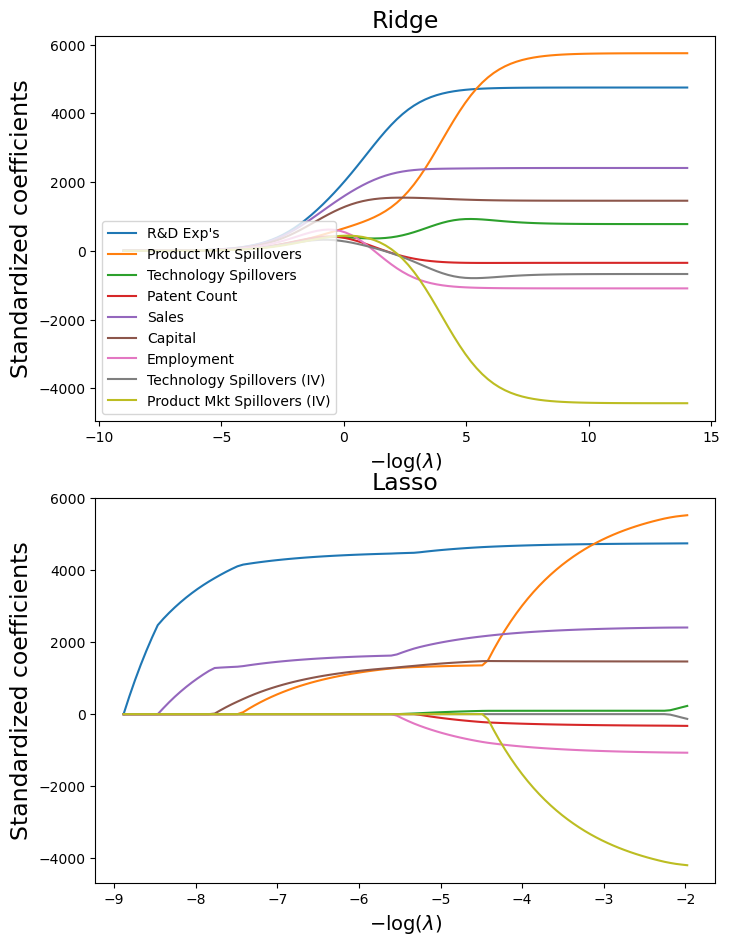

In [43]:
#path_fig, ax = plt.subplots(figsize=(10,5))
path_fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,11))

soln_path_ridge.plot(ax=ax1, legend=False)
ax1.set_xlabel('$-\log(\lambda)$', fontsize=14)
ax1.set_ylabel('Standardized coefficients', fontsize=17)
ax1.legend(loc='lower left')
ax1.set_title('Ridge', fontsize=17)

soln_path.plot(ax=ax2, legend=False)
#ax2.legend(loc='upper left')
ax2.set_xlabel('$-\log(\lambda)$', fontsize=14)
ax2.set_ylabel('Standardized coefficients', fontsize=17)
ax2.set_title('Lasso', fontsize=17)

# save figure
# plt.savefig('lasso_coef.png')
plt.savefig('lasso_ridge_coefs.png',bbox_inches='tight')

## Cross-Validation plot

In [27]:
# lassoCV_fig, ax = plt.subplots(figsize=(8,8))
# ax.errorbar(-np.log(tuned_lasso.alphas_),
#             tuned_lasso.mse_path_.mean(1),
#             yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
# ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
# #ax.set_ylim([50000,250000])
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Cross-validated MSE', fontsize=20)

# # save figure
# plt.savefig('lasso_cv.png')

In [28]:
# # comparing lambdas

# # tuned alphas
# print("LASSO: ", tuned_lasso.alpha_)
# print("Ridge: ", tuned_ridge.alpha_)

In [29]:
# print(-np.log(tuned_lasso.alpha_))

# Regression Tree

In [30]:
# Splitting sample
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0)
feature_names = list(D.columns)

In [31]:
# reg = DTR(max_depth=3)
# reg.fit(X_train, y_train)
# ax = plt.subplots(figsize=(12,12))[1]
# plot_tree(reg,
#           feature_names=feature_names,
#           ax=ax);

In [32]:
# # Find best pruning for tree
# ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
# kfold = skm.KFold(5,
#                   shuffle=True,
#                   random_state=10)
# grid = skm.GridSearchCV(reg,
#                         {'ccp_alpha': ccp_path.ccp_alphas},
#                         refit=True, # retrains on best alpha
#                         cv=kfold,
#                         scoring='neg_mean_squared_error')
# G = grid.fit(X_train, y_train)

In [33]:
# # Get prediction error
# best_ = grid.best_estimator_
# tree_mse = np.mean((y_test - best_.predict(X_test))**2)
# tree_mse

In [34]:
# # Output pruned Regression Tree
# ax = plt.subplots(figsize=(12,12))[1]
# plot_tree(G.best_estimator_,
#           feature_names=feature_names,
#           ax=ax);
# plt.savefig("pruned_tree.png")

# Random Forest

In [35]:
RF_tree = RF(max_features=3, # Random forest model
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_tree.predict(X_test)
rf_mse = np.mean((y_test - y_hat_RF)**2)
rf_mse

In [36]:
feature_imp = pd.DataFrame(
    {'importance':RF_tree.feature_importances_},
    index=feature_names) # Must include feature importance in report
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp

,importance
rxrd,0.222634
rsales,0.219054
rppent,0.125117
emp,0.112862
gspillsic,0.093766
gspillsicIV,0.086421
gspilltec,0.055947
gspilltecIV,0.048787
pat_count,0.035413


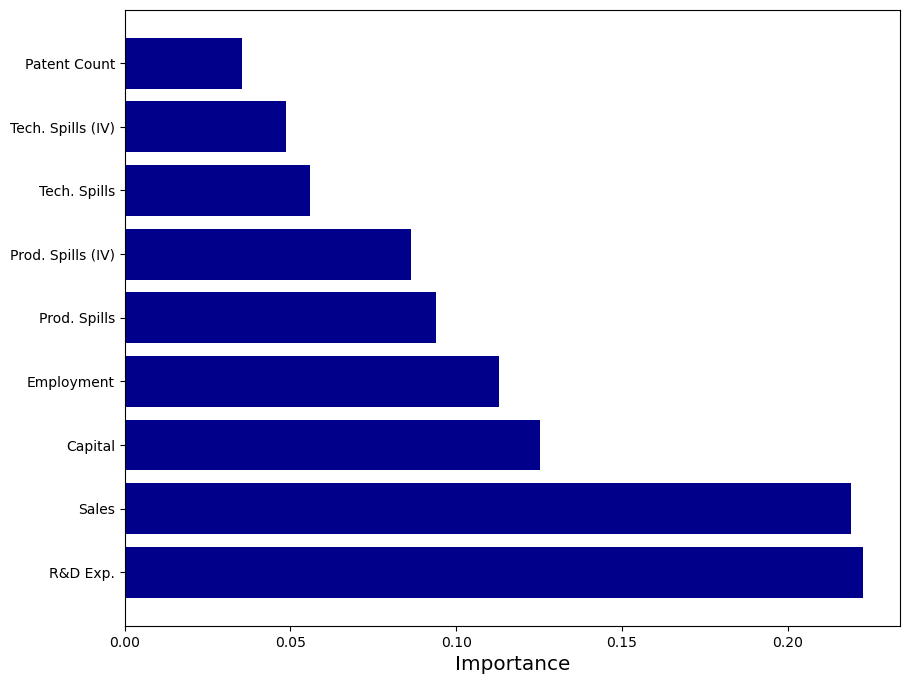

In [37]:
# print(feature_imp.sort_values(by='importance', ascending=False).to_latex()) # print latex output

# Change to full variable names
var_dict = {
    'rxrd': 'R&D Exp.',
    'rsales': 'Sales',
    'rppent': 'Capital',
    'emp': 'Employment',
    'gspillsic': 'Prod. Spills',
    'gspilltec': 'Tech. Spills',
    'gspillsicIV': 'Prod. Spills (IV)',
    'gspilltecIV': 'Tech. Spills (IV)',
    'pat_count': 'Patent Count'
    
}

feature_imp = feature_imp.rename(index=var_dict)

# plot importance values
fig = plt.figure(figsize=(10,8))

#plt.barh(feature_imp.index, feature_imp.importance, color ='darkblue', 
#        width = 0.4)

plt.barh(feature_imp.index, feature_imp.importance, color ='darkblue')


plt.xlabel('Importance', fontsize='x-large')
#plt.title('Importance of Random Forest Regressors for Firm Market Value')

plt.savefig('RFimp.png')

# Bagging

In [38]:
# bag = RF(max_features=X_train.shape[1], random_state=0)
# bag.fit(X_train, y_train)

In [39]:
# ax = plt.subplots(figsize=(8,8))[1]
# y_hat_bag = bag.predict(X_test)
# ax.scatter(y_hat_bag, y_test)
# bag_mse = np.mean((y_test - y_hat_bag)**2)
# bag_mse

# Boosting

In [40]:
# boost = GBR(n_estimators=5000, # Gradient Boosting Regressor
#                    learning_rate=0.001,
#                    max_depth=3,
#                    random_state=0)
# boost.fit(X_train, y_train)

In [41]:
# test_error = np.zeros_like(boost.train_score_)
# for idx, y_ in enumerate(boost.staged_predict(X_test)):
#    test_error[idx] = np.mean((y_test - y_)**2)

# plot_idx = np.arange(boost.train_score_.shape[0])
# ax = plt.subplots(figsize=(8,8))[1]
# ax.plot(plot_idx,
#         boost.train_score_,
#         'b',
#         label='Training')
# ax.plot(plot_idx,
#         test_error,
#         'r',
#         label='Test')
# ax.legend();

# boost_mse = min(test_error)

In [42]:
# # XG Boost
# y = df['rmkvaf']
# # Convert the data into XGBoost's DMatrix format
# dtrain = xgb.DMatrix(X, label=y)

# # Define the parameters for the XGBoost model
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'eta': 0.1,
#     'max_depth': 5,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# # Train the XGBoost model with the optimal number of boosting rounds
# model = xgb.train(params, dtrain, num_boost_round= 10)

# # Make predictions 
# y_pred = model.predict(dtrain)

# # Calculate and print the Mean Squared Error (MSE)
# mse = mean_squared_error(y, y_pred)
# print("Mean Squared Error:", mse)
# print("Prev. MSE: 40865396.0")

# plt.figure(figsize=(8, 6))
# plt.scatter(y, y_pred, c='grey', alpha=0.3)
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# plt.xlabel('True Y')
# plt.ylabel('Predicted Y')
# plt.title('Y vs Predicted Y (Y hat)')
# plt.show()

# Comparing Test Errors

In [43]:
# # Tree
# print('Tree: ', tree_mse)
# # Bag
# print('Bag: ', bag_mse)
# # Random Forest
# print('Random Forest: ', rf_mse)
# # Boost
# print('Boost: ', boost_mse)

# # Make table
# error_tbl = {
#     'model' : ['Tree', 'Bag', 'Random Forest', 'Boost'],
#     'MSE' : [tree_mse, bag_mse, rf_mse, boost_mse]
# }
# error_tbl = pd.DataFrame(data=error_tbl)
# print(error_tbl.to_latex())

# Predicting Market value of spillovers across years

In [44]:
# # Use Optimal LASSO coefficients - remember to rescale from their standardization back to unit values.
# print(x_vars.columns[1],': ',tuned_lasso.coef_[0]) # index 0 for x_vars is constant term
# print(x_vars.columns[2],': ',tuned_lasso.coef_[1]) # so 1st variable is at index 1


In [45]:
# # rescaling lasso coefficients
# coef_tec = tuned_lasso.coef_[0]/df['gspilltecIV'].std()
# coef_sic = tuned_lasso.coef_[1]/df['gspillsicIV'].std() 

In [46]:
# df['firmval_tec'] = df['gspilltecIV']*coef_tec
# df['firmval_sic'] = df['gspillsicIV']*coef_sic

In [47]:
# df[['rmkvaf','firmval_tec','firmval_sic']]

In [48]:
# print(df['rmkvaf'].sum())
# print(df['firmval_tec'].sum())
# # Generate predictions for each firm

# # Aggregate across years

In [49]:
# Using simple regression

# tech spillovers - resume later as I have methodological issues
# drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]
# x_vars_fe = x_vars.drop(columns=drop_columns)
# y_var = df['rmkvaf']

# tech_ml = sm.OLS(y_var,x_vars_fe[['const','gspilltecIV']]).fit()
# tech_ml.summary()

# Impact of spillovers on firm value over time

In [50]:
# Include confidence intervals. Use 2 or 5 year intervals if need more statistical power
# Try with PLR DML to compare results - separate bar i.e. for each year, one OLS bar and one DML bar
# Separate plots for tech/product market spillovers

# build year-spillover interaction terms
years = df.year.astype(str).sort_values().unique()

years = years[1:] # remove first year as ref category

spillovers = ['gspilltecIV','gspillsicIV']

for spillover in spillovers:
    for year in years:
        col_name = f"{spillover}X{year}"
        x_vars[col_name] = x_vars[spillover]*x_vars[year]

# drop reference year dummy
#x_vars = x_vars.drop(columns=['1981'])
#fixed_effects.remove('1981')

In [51]:
# Estimate effect of spillovers on firm value, OLS w/o firm FE's. Estimate spillovers separately, then together.

# Full model
# year_model1 = sm.OLS(y_var,x_vars).fit(cov_type='HC0')
# year_model1.summary()

In [52]:
# Tech spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

# year_model2 = sm.OLS(y_var,x_vars_nofe).fit(cov_type='HC0')
# year_model2.summary()

In [53]:
# Tech spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)
x_vars_fe = x_vars_fe.drop(columns=['gspillsic','gspilltec'])

df_pl = df_pl.reset_index()
df_pl['year1'] = df_pl['year'].astype('category')
df_pl = df_pl.set_index(['i','year'])

#formula = 'rmkvaf ~ 1 + gspilltecIV + pat_count + rsales + rppent + emp + rxrd + year1*gspilltecIV + EntityEffects'
#year_model3 = PanelOLS.from_formula(formula, df_pl).fit(cov_type='robust')
year_model3 = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
#year_model3.summary()

Results highly depend on the firm FE's. Wrong sign for tech, insignificant for product market. Unobserved firm-related variables play a role?

In [54]:
# Product spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspilltecIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

# year_model4 = sm.OLS(y_var,x_vars_nofe).fit(cov_type='HC0')
# year_model4.summary()

In [55]:
# Product spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)
x_vars_fe = x_vars_fe.drop(columns=['gspillsic','gspilltec'])

year_model5 = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
#year_model5.summary()

In [56]:
# Product Spillovers, all FE's, 5-year intervals

# Create 5-year intervals
#years = np.append(years,'1980')

df['1980_84'] = df['year'].isin([1980,1981,1982,1983,1984])
df['1985_89'] = df['year'].isin([1985,1986,1987,1988,1989])
df['1990_94'] = df['year'].isin([1990,1991,1992,1993,1994])
df['1995_99'] = df['year'].isin([1995,1996,1997,1998,1999])

x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']
intervals = ['1980_84','1985_89','1990_94','1995_99']
#years = df.year.sort_values().unique()

for year in years:
    try:
        fixed_effects.remove(year)
    except ValueError:
        continue

for interval in intervals:
    fixed_effects.append(interval)

for col in fixed_effects:
    x_vars.append(col)

x_vars = df[x_vars]
x_vars = sm.add_constant(x_vars)
x_vars = x_vars.astype(float) # converts categorical booleans to floats

for spillover in spillovers:
    for interval in intervals:
        col_name = f"{spillover}X{interval}"
        x_vars[col_name] = x_vars[spillover]*x_vars[interval]

In [57]:
drop_columns = [col for col in x_vars.columns if 'gspilltecIV' in col]

x_vars_fe = x_vars.drop(columns=drop_columns)
x_vars_fe = x_vars_fe.drop(columns=['1980_84', 'gspillsicIVX1980_84']) # drop ref category

y_var = df['rmkvaf']

int_modelsic = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
#int_modelsic.summary()

In [58]:
# Tech spillovers, 5-year intervals
drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]

x_vars_fe = x_vars.drop(columns=drop_columns)
x_vars_fe = x_vars_fe.drop(columns=['1980_84', 'gspilltecIVX1980_84']) # drop ref category

y_var = df['rmkvaf']

int_modeltec = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
#int_modeltec.summary()

## Graphing Product Market Spillovers over time

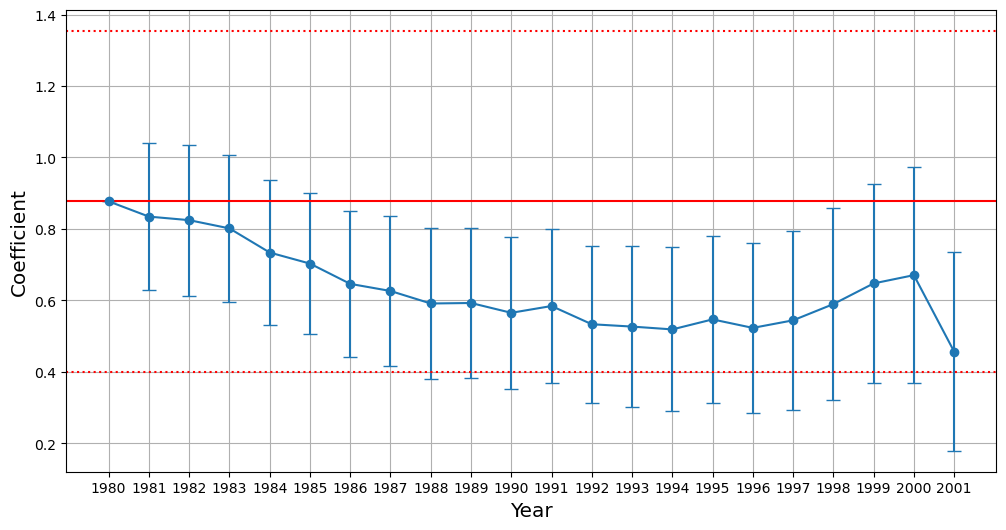

In [59]:
# grab estimates. Add non-interactive term to each year coefficient
# Build Dataframe of year, coefficient, conf intervals

# use years to interate through
# years = np.append(years, '1981')
# years = years.sort_values()

ref_year = '1980'
time_coefs_sic = {
    'year': np.append(years,ref_year),
    'coef': [np.nan for i in range(0,len(years)+1)],
    'CI_l': [np.nan for i in range(0,len(years)+1)],
    'CI_h': [np.nan for i in range(0,len(years)+1)],
    'se': [np.nan for i in range(0,len(years)+1)]
}

time_coefs_sic = pd.DataFrame(time_coefs_sic)
time_coefs_sic = time_coefs_sic.sort_values(by='year').reset_index(drop=True)

conf_intervals = year_model5.conf_int(alpha=0.05, cols=None)
s_errors = year_model5.HC0_se

# grab coefficients and confidence intervals
ref_year = '1980'
coef_ref = year_model5.params['gspillsicIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',1].values[0]

for year in time_coefs_sic['year'].unique():
    if year == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspillsicIVX{year}"
        coef = year_model5.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h


time_coefs_sic['upper'] = time_coefs_sic['CI_h'] - time_coefs_sic['coef']
time_coefs_sic['lower'] = time_coefs_sic['coef'] - time_coefs_sic['CI_l']
time_coefs_sic.loc[time_coefs_sic['year'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_sic[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_sic['year'],y=time_coefs_sic['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='solid', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year', fontsize='x-large')
plt.ylabel('Coefficient', fontsize='x-large')
#plt.title('Effect of Product Market Spillovers Over Time')
plt.grid(True)
#plt.show()

plt.savefig('sicyrs.png',bbox_inches='tight')

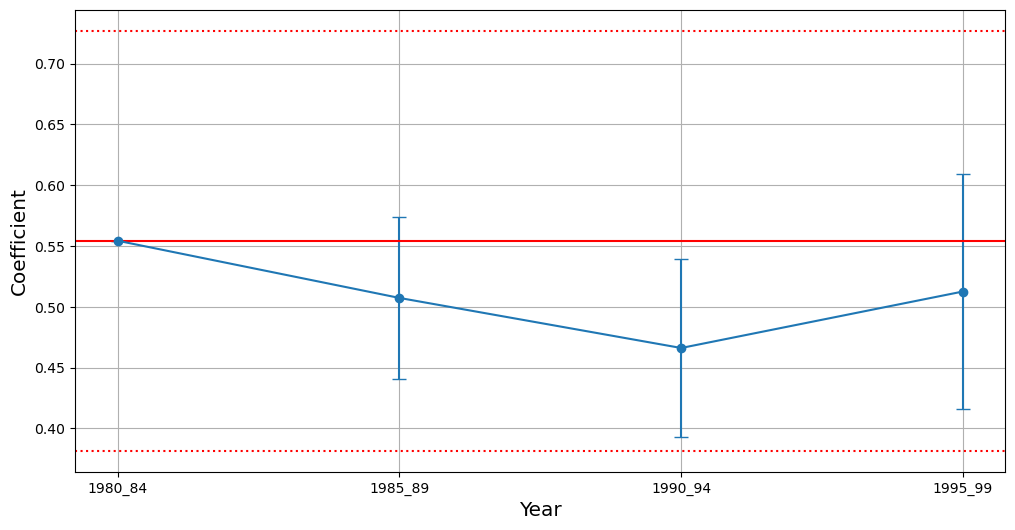

In [60]:
# Plot 5 Year Intervals

ref_year = '1980_84'
time_coefs_sic = {
    'interval': intervals,
    'coef': [np.nan for i in range(0,len(intervals))],
    'CI_l': [np.nan for i in range(0,len(intervals))],
    'CI_h': [np.nan for i in range(0,len(intervals))],
    'se': [np.nan for i in range(0,len(intervals))]
}

time_coefs_sic = pd.DataFrame(time_coefs_sic)
time_coefs_sic = time_coefs_sic.sort_values(by='interval').reset_index(drop=True)

conf_intervals = int_modelsic.conf_int(alpha=0.05, cols=None)
s_errors = int_modelsic.HC0_se

# grab coefficients and confidence intervals
coef_ref = int_modelsic.params['gspillsicIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',1].values[0]

for interval in time_coefs_sic['interval'].unique():
    if interval == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspillsicIVX{interval}"
        coef = int_modelsic.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_h'] = ci_h


time_coefs_sic['upper'] = time_coefs_sic['CI_h'] - time_coefs_sic['coef']
time_coefs_sic['lower'] = time_coefs_sic['coef'] - time_coefs_sic['CI_l']
time_coefs_sic.loc[time_coefs_sic['interval'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_sic[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_sic['interval'],y=time_coefs_sic['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='solid', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year', fontsize='x-large')
plt.ylabel('Coefficient', fontsize='x-large')
#plt.title('Effect of Product Market Spillovers, 5-Year Intervals')
plt.grid(True)
#plt.show()

plt.savefig('sic5yr.png')

## Tech Spillovers over time

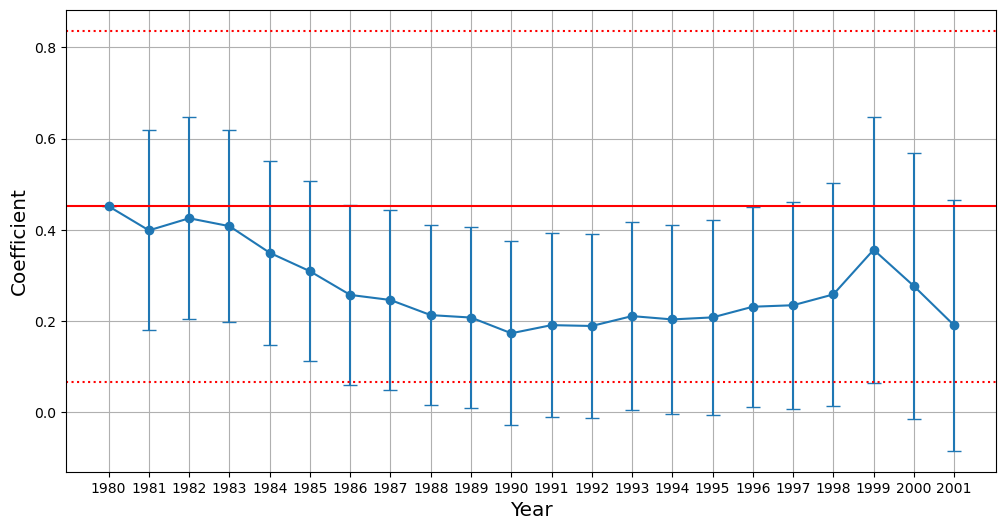

In [61]:
ref_year = '1980'
time_coefs_tec = {
    'year': np.append(years,ref_year),
    'coef': [np.nan for i in range(0,len(years)+1)],
    'CI_l': [np.nan for i in range(0,len(years)+1)],
    'CI_h': [np.nan for i in range(0,len(years)+1)],
    'se': [np.nan for i in range(0,len(years)+1)]
}

time_coefs_tec = pd.DataFrame(time_coefs_tec)
time_coefs_tec = time_coefs_tec.sort_values(by='year').reset_index(drop=True)

conf_intervals = year_model3.conf_int(alpha=0.05, cols=None)
s_errors = year_model3.HC0_se

# grab coefficients and confidence intervals
ref_year = '1980'
coef_ref = year_model3.params['gspilltecIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',1].values[0]

for year in time_coefs_tec['year'].unique():
    if year == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspilltecIVX{year}"
        coef = year_model3.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_h'] = ci_h


time_coefs_tec['upper'] = time_coefs_tec['CI_h'] - time_coefs_tec['coef']
time_coefs_tec['lower'] = time_coefs_tec['coef'] - time_coefs_tec['CI_l']
time_coefs_tec.loc[time_coefs_tec['year'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_tec[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_tec['year'],y=time_coefs_tec['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='solid', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year', fontsize='x-large')
plt.ylabel('Coefficient', fontsize='x-large')
#plt.title('Effect of Technology Spillovers Over Time')
plt.grid(True)
#plt.show()

plt.savefig('techyrs.png',bbox_inches='tight')

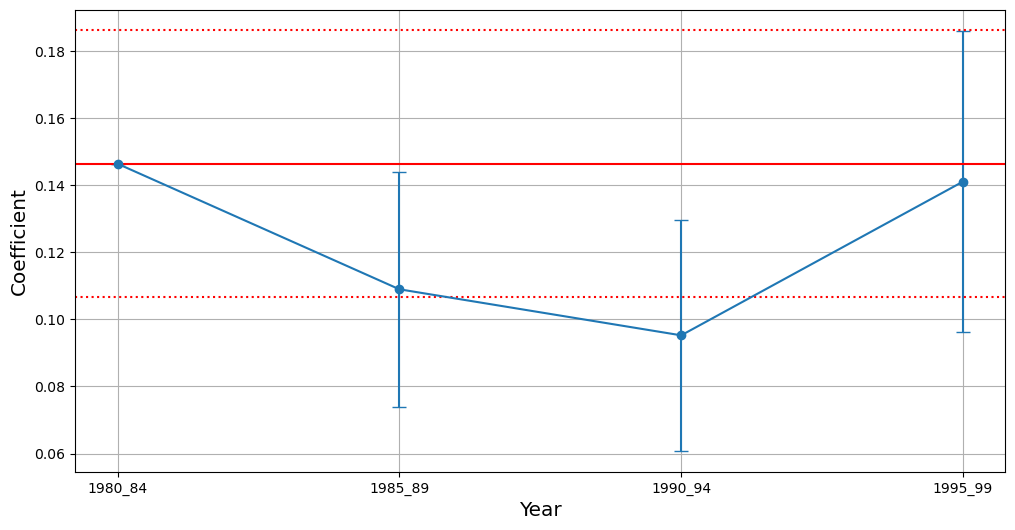

In [62]:
# Plot 5 Year Intervals, Tech spillovers

ref_year = '1980_84'
time_coefs_tec = {
    'interval': intervals,
    'coef': [np.nan for i in range(0,len(intervals))],
    'CI_l': [np.nan for i in range(0,len(intervals))],
    'CI_h': [np.nan for i in range(0,len(intervals))],
    'se': [np.nan for i in range(0,len(intervals))]
}

time_coefs_tec = pd.DataFrame(time_coefs_tec)
time_coefs_tec = time_coefs_tec.sort_values(by='interval').reset_index(drop=True)

conf_intervals = int_modeltec.conf_int(alpha=0.05, cols=None)
s_errors = int_modeltec.HC0_se

# grab coefficients and confidence intervals
coef_ref = int_modeltec.params['gspilltecIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',1].values[0]

for interval in time_coefs_tec['interval'].unique():
    if interval == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspilltecIVX{interval}"
        coef = int_modeltec.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_h'] = ci_h


time_coefs_tec['upper'] = time_coefs_tec['CI_h'] - time_coefs_tec['coef']
time_coefs_tec['lower'] = time_coefs_tec['coef'] - time_coefs_tec['CI_l']
time_coefs_tec.loc[time_coefs_tec['interval'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_tec[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_tec['interval'],y=time_coefs_tec['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='solid', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year', fontsize='x-large')
plt.ylabel('Coefficient', fontsize='x-large')
#plt.title('Effect of Technology Spillovers, 5-Year Intervals')
plt.grid(True)
#plt.show()

plt.savefig('tech5yr.png')

# Propensity Score / IPW Model

In [63]:
# Create binary treatment variable - above-mean spillovers
df['sic_abv_mn'] = df['gspillsic'] > df['gspillsic'].mean()
df['sic_abv_mn'] = df['sic_abv_mn'].astype(int)

df['tec_abv_mn'] = df['gspilltec'] > df['gspilltec'].mean()
df['tec_abv_mn'] = df['tec_abv_mn'].astype(int)

form_sic = 'sic_abv_mn ~ gspilltecIV + pat_count + rxrd + rsales + rppent + emp'
form_tec = 'tec_abv_mn ~ gspillsicIV + pat_count + rxrd + rsales + rppent + emp'
df['const'] = 1

from sklearn.linear_model import LogisticRegression
ps_sic = LogisticRegression(max_iter=1000).fit(y=df['sic_abv_mn'], X=df[['gspilltecIV','pat_count','rxrd','rsales','rppent','emp']])
ps_tec = LogisticRegression(max_iter=1000).fit(y=df['tec_abv_mn'], X=df[['gspillsicIV','pat_count','rxrd','rsales','rppent','emp']])

# initialize columns storing prop scores (get KeyError otherwise)
df['ps_tec'] = 0
df['ps_sic'] = 0

df['ps_tec'] = ps_tec.predict_proba(df[['gspillsicIV','pat_count','rxrd','rsales','rppent','emp']])
df['ps_sic'] = ps_sic.predict_proba(df[['gspilltecIV','pat_count','rxrd','rsales','rppent','emp']])



### Positivity Graph

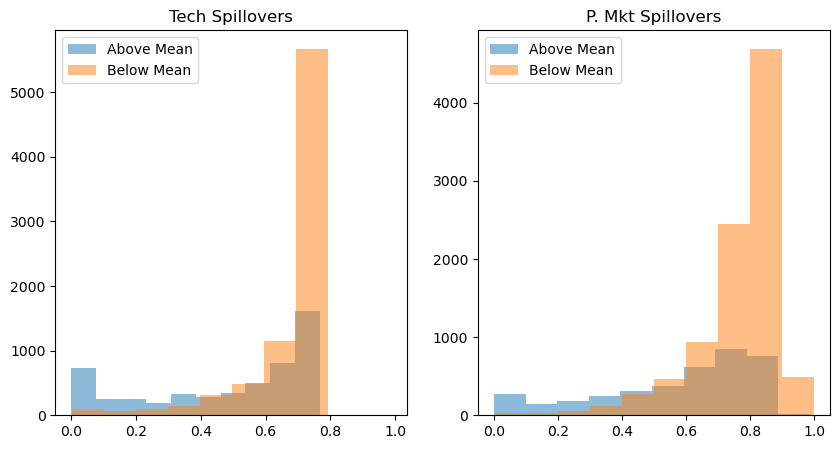

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot 1: positivity graph for gspilltec
ax1.hist(df.loc[df.tec_abv_mn == 1, 'ps_tec'], label='Above Mean', alpha=0.5)
ax1.hist(df.loc[df.tec_abv_mn == 0, 'ps_tec'], label='Below Mean', alpha=0.5)
ax1.legend()
ax1.set_title("Tech Spillovers")

# plot 2: positivity graph for gspillsic
ax2.hist(df.loc[df.sic_abv_mn == 1, 'ps_sic'], label='Above Mean', alpha=0.5)
ax2.hist(df.loc[df.sic_abv_mn == 0, 'ps_sic'], label='Below Mean', alpha=0.5)
ax2.legend()
ax2.set_title("P. Mkt Spillovers")

plt.show()

In [88]:
# Find ATE for tech spillovers

ps_df = df.drop(df.query("ps_tec<=0.005 | ps_tec>0.995").index, axis=0)

weight_t = 1/ps_df.query("tec_abv_mn==1")["ps_tec"]
weight_nt = 1/(1-ps_df.query("tec_abv_mn==0")["ps_tec"])
print("Original Sample Size", ps_df.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

weight = ((ps_df["tec_abv_mn"]-ps_df["ps_tec"]) /
          (ps_df["ps_tec"]*(1-ps_df["ps_tec"])))

y1 = sum(ps_df.query("tec_abv_mn==1")["rmkvaf"]*weight_t) / len(ps_df)
y0 = sum(ps_df.query("tec_abv_mn==0")["rmkvaf"]*weight_nt) / len(ps_df)

ate = np.mean(weight * ps_df["rmkvaf"])

# Save results in table
results = pd.DataFrame(data = np.array([
    ['Technology', y1, y0, ate],
]),
    columns = ['Spillover','Y1','Y0','ATE'])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Original Sample Size 12908
Treated Population Sample Size 26834.9196979738
Untreated Population Sample Size 28419.28384468084
Y1: 20932.14345871008
Y0: 2843.63063239611
ATE 18088.512826313974


In [91]:
# Find ATE for product market spillovers

ps_df = df.drop(df.query("ps_sic<=0.005 | ps_sic>0.995").index, axis=0)

weight_t = 1/ps_df.query("sic_abv_mn==1")["ps_sic"]
weight_nt = 1/(1-ps_df.query("sic_abv_mn==0")["ps_sic"])
print("Original Sample Size", ps_df.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

weight = ((ps_df["sic_abv_mn"]-ps_df["ps_sic"]) /
          (ps_df["ps_sic"]*(1-ps_df["ps_sic"])))

y1 = sum(ps_df.query("sic_abv_mn==1")["rmkvaf"]*weight_t) / len(ps_df)
y0 = sum(ps_df.query("sic_abv_mn==0")["rmkvaf"]*weight_nt) / len(ps_df)

ate = np.mean(weight * ps_df["rmkvaf"])

results.loc[1] = ['Product Market', y1, y0, ate]

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Original Sample Size 13141
Treated Population Sample Size 15519.974098407933
Untreated Population Sample Size 57834.55340779936
Y1: 29581.59083975519
Y0: 15375.19929874389
ATE 14206.391541011297


In [ ]:
# Finish output table for report
results[['Y1','Y0','ATE']] = results[['Y1','Y0','ATE']].astype(float)
results = results.set_index('Spillover').round(2)

In [105]:
print(results.to_latex())

\begin{tabular}{lrrr}
\toprule
 & Y1 & Y0 & ATE \\
Spillover &  &  &  \\
\midrule
Technology & 20932.140000 & 2843.630000 & 18088.510000 \\
Product Market & 29581.590000 & 15375.200000 & 14206.390000 \\
\bottomrule
\end{tabular}



# Learner Models

In [66]:
# Based on Meta Learner Notebook from Causal Inference for the Brave & True

In [106]:
# import req'd functions - downloaded to my Git folder from CIBT GitHub: https://github.com/matheusfacure/python-causality-handbook/tree/master
from nb21 import cumulative_gain, elast

y = 'rmkvaf'
X = ['gspillsicIV','pat_count','rxrd','rsales','rppent','emp']
T = 'tec_abv_mn'

# Create Train/Test set
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(df[X + [T]],
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0)


In [107]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [117]:
# S-Learner

from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=7, min_child_samples=30)
s_learner.fit(X_train[X+[T]], y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 9327, number of used features: 7
[LightGBM] [Info] Start training from score 3557.930576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMRegressor(max_depth=7, min_child_samples=30)

In [118]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

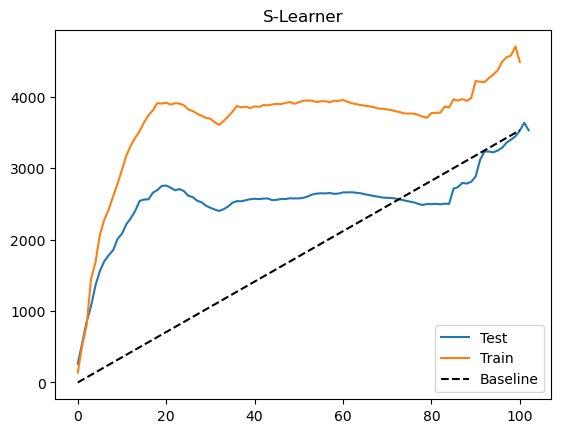

In [119]:
# Plot Gain Curve
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");

In [122]:
# T-learner

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query('tec_abv_mn==0')[X], train.query('tec_abv_mn==0')[y])
m1.fit(train.query('tec_abv_mn==1')[X], train.query('tec_abv_mn==1')[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 5615, number of used features: 6
[LightGBM] [Info] Start training from score 1772.321963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\marti\Documents\GitHub\ECO2425-Causal-ML\nb21.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
C:\Users\marti\Documents\GitHub\ECO2425-Causal-ML\nb21.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


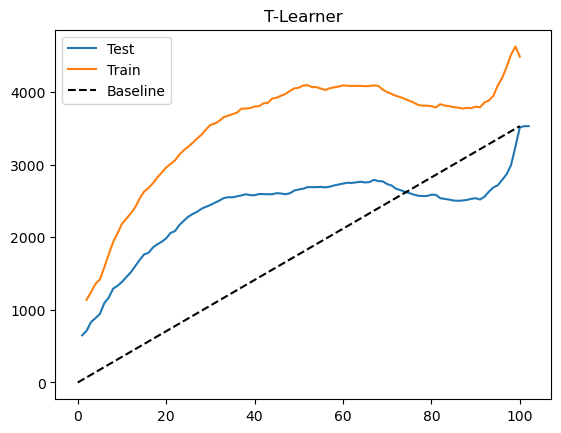

In [123]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner");

In [127]:
# X-Learner

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty=None) 

m0.fit(train.query('tec_abv_mn==0')[X], train.query('tec_abv_mn==0')[y])
m1.fit(train.query('tec_abv_mn==1')[X], train.query('tec_abv_mn==1')[y])
                       
g.fit(train[X], train[T]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 5615, number of used features: 6
[LightGBM] [Info] Start training from score 1772.321963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [130]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 5615, number of used features: 6
[LightGBM] [Info] Start training from score -348.259796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [131]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

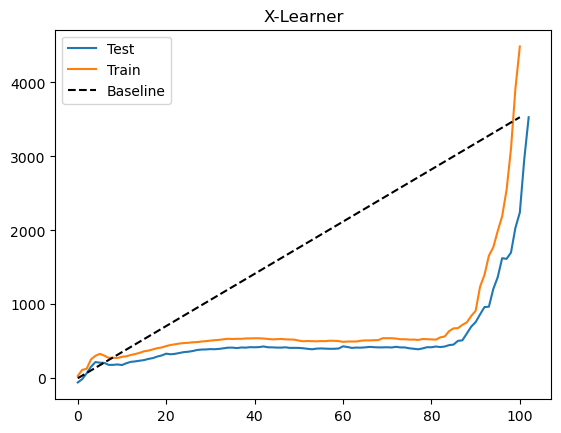

In [132]:
# Plot gain curve
gain_curve_test = cumulative_gain(x_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

# DAG model and testing

In [63]:
# From implementation in Causal Discovery in Python

DAG3 = """graph [
directed 1

node [
    id 0
    label "rmkvaf"
    ]

node [
    id 1
    label "rxrd"
    ]
    
node [
    id 2
    label "rsales"
    ]

node [
    id 3
    label "gspilltecIV"
    ]

node [
    id 4
    label "gspillsicIV"
    ]

node [
    id 5
    label "pat_count"
    ]

node [
    id 7
    label "rppent"
    ]

edge [
    source 5
    target 0
    ]

edge [
    source 5
    target 7
    ]


edge [
    source 3
    target 1
    ]


edge [
    source 4
    target 1
    ]


edge [
    source 4
    target 2
    ]


edge [
    source 1
    target 7
    ]


edge [
    source 1
    target 5
    ]


edge [
    source 7
    target 2
    ]


edge [
    source 2
    target 0
    ]

edge [
    source 7
    target 0
    ]

]
    
    """

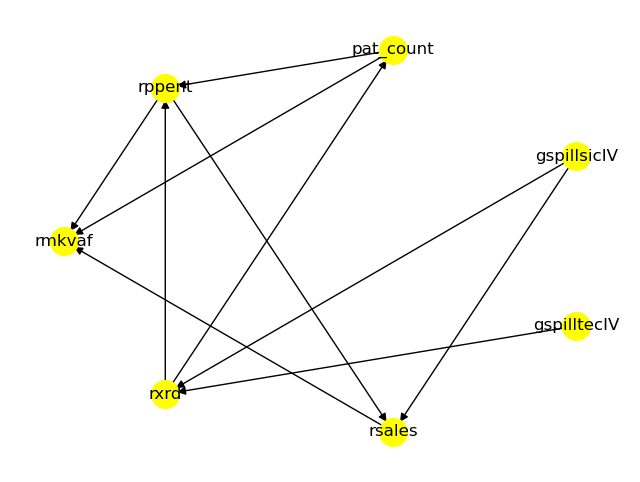

In [64]:
model = CausalModel(
    data=df,
    treatment='gspilltecIV',
    outcome='rmkvaf',
    graph=DAG3)

model.view_model()

In [65]:
# identify estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[rmkvaf])
d[gspilltecIV]           
Estimand assumption 1, Unconfoundedness: If U→{gspilltecIV} and U→rmkvaf then P(rmkvaf|gspilltecIV,,U) = P(rmkvaf|gspilltecIV,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [66]:
# obtain estimates
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(estimate.value)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
0.12296998685337712


In [67]:
# refutation test
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

print(refute_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value